<a href="https://colab.research.google.com/github/LawsonHutter/RNN_working_memory/blob/main/RNN_working_memory_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 1000  # number of neurons
model['g'] = 0.95  # gain of synaptic weights in pool
model['sp'] = 0.25  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [3]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [4]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

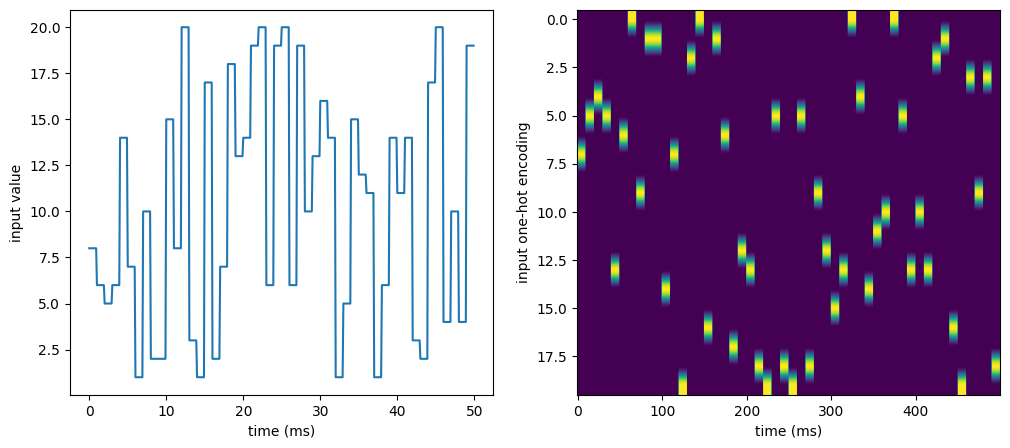

In [5]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

In [8]:
print(onehot.shape)
print(stream.shape)

(20, 600)
(600,)


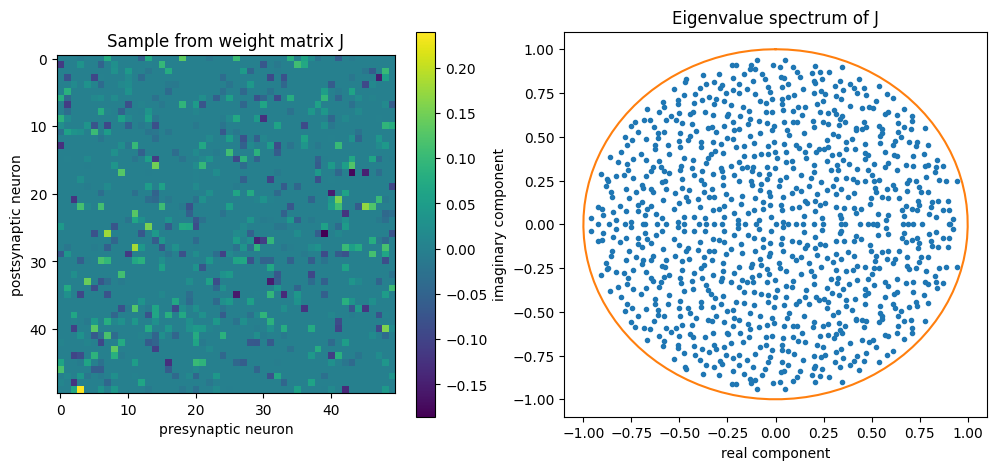

In [ ]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

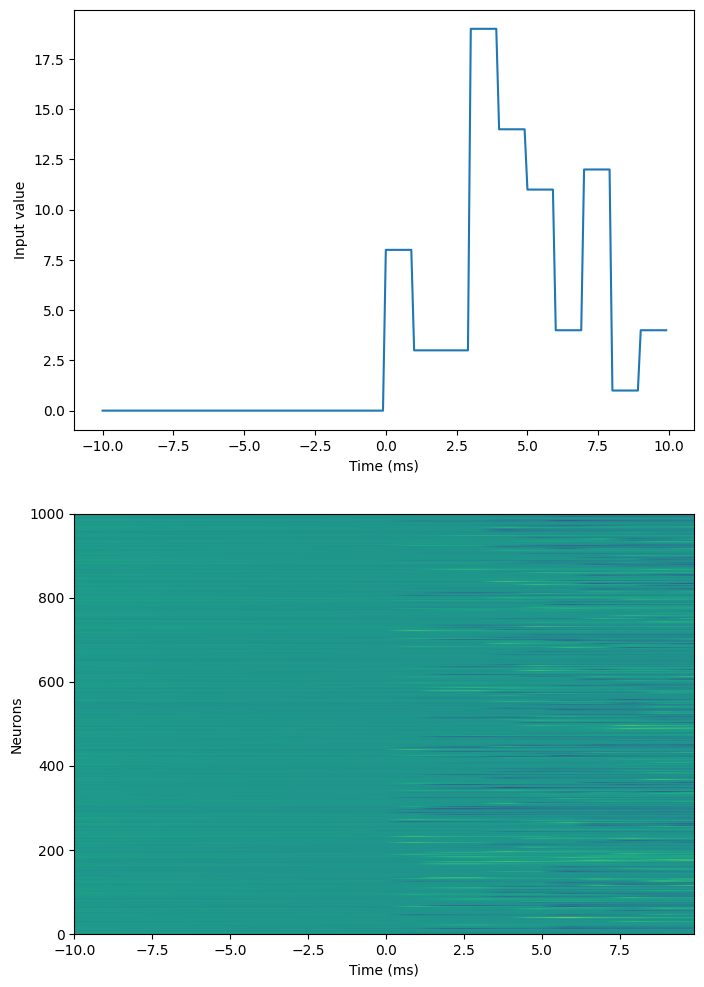

In [ ]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

In [77]:
# Our Imports
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score

# Q1)

In [ ]:
# Using different input stream as test set resulted in
# poor performance of the model.

"""
sequence_length = 10

# Set G parameter
model['g'] = 1

# Generate Training Data
onehot, inputs_train = make_input(sequence_length, model)

# Generate Testing Data
onehot, inputs_test = make_input(sequence_length, model)

# initialize the firing rates for Training Data
firing_rates_train = np.zeros((model['N'], len(inputs_train)))
firing_rates_train[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(inputs_train)-1):
  firing_rates_train[:,t+1] = step(firing_rates_train[:,t], onehot[:,t], model)

# initialize the firing rates for Testing Data
firing_rates_test = np.zeros((model['N'], len(inputs_train)))
firing_rates_test[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(inputs_test)-1):
  firing_rates_test[:,t+1] = step(firing_rates_test[:,t], onehot[:,t], model)

# Set to numpy
inputs_train = np.array(inputs_train)
inputs_test = np.array(inputs_test)

firing_rates_train = np.array(firing_rates_train.T)
firing_rates_test = np.array(firing_rates_test.T)

"""

"\nsequence_length = 10\n\n# Set G parameter\nmodel['g'] = 1\n\n# Generate Training Data\nonehot, inputs_train = make_input(sequence_length, model)\n\n# Generate Testing Data\nonehot, inputs_test = make_input(sequence_length, model)\n\n# initialize the firing rates for Training Data\nfiring_rates_train = np.zeros((model['N'], len(inputs_train)))\nfiring_rates_train[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))\n\nfor t in range(len(inputs_train)-1):\n  firing_rates_train[:,t+1] = step(firing_rates_train[:,t], onehot[:,t], model)\n\n# initialize the firing rates for Testing Data\nfiring_rates_test = np.zeros((model['N'], len(inputs_train)))\nfiring_rates_test[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))\n\nfor t in range(len(inputs_test)-1):\n  firing_rates_test[:,t+1] = step(firing_rates_test[:,t], onehot[:,t], model)\n\n# Set to numpy\ninputs_train = np.array(inputs_train)\ninputs_test = np.array(inputs_test)\n\nfiring_rates_train = np.array(firing_rates_train.T)\nfirin

In [ ]:
sequence_length = 10

# Set G parameter
model['g'] = 1

# Generate Data
onehot, input_stream = make_input(sequence_length, model)

# initialize the firing rates
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)
    
input_stream = np.array(input_stream)
firing_rates = np.array(firing_rates.T)

In [ ]:
print(input_stream.shape)
print(firing_rates.shape)

(200,)
(200, 1000)


In [ ]:
# Determin X value and restructure data accordingly
max_X = 25

# New data sets for each value of x
Y_train = []
X_train = []

Y_test = []
X_test = []

#Split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates, input_stream, test_size=0.2, random_state=42)

# Append the base case (X = 0)
Y_train.append(Y_train_)
X_train.append(X_train_)
Y_test.append(Y_test_)
X_test.append(X_test_)

# Restructure data, deleting the first x input sets and last x firing rates sets 
for x in range(1, max_X):
    # Training data
    input_stream_ = input_stream[x:]
    firing_rates_ = firing_rates[:-(x), :]
    
    #Split
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates_, input_stream_, test_size=0.2, random_state=42)

    Y_train.append(Y_train_)
    X_train.append(X_train_)
    Y_test.append(Y_test_)
    X_test.append(X_test_)

In [ ]:
# Useful shapes to consider, (size-x, 1000)
print(Y_train[0].shape)
print(X_train[0].shape)
print(Y_test[0].shape)
print(X_test[0].shape)

(160,)
(160, 1000)
(40,)
(40, 1000)


In [ ]:
# Normalize input data
for x in range(0, max_X):
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()

    X_train[x] = scaler_train.fit_transform(X_train[x])
    X_test[x] = scaler_test.fit_transform(X_test[x])

In [ ]:
# Create a list to store the models
models = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

# Loop over the range of x values
for x in range(0, max_X):
    
    # Define the model architecture
    model_ = Sequential()
    model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))
    model_.add(Dense(1))

    # Add a Dense output layer with a single unit
    model_.add(Dense(1))

    # Compile the model with mean squared error loss
    model_.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models.append(model_)

In [ ]:
X_train[x].reshape(1, -1, 1000).shape

(1, 140, 1000)

In [ ]:
# Train the models for each value of x
for x in range(0, max_X):
    # Train the model on the firing rates and targets
    model_ = models[x]
    model_.fit(X_train[x].reshape(-1, 1, 1000), Y_train[x], epochs=100, batch_size=32, callbacks=[early_stop])

    # Create a folder for the models if it doesn't exist
    if not os.path.exists('models1'):
        os.makedirs('models1')

    # Save the model to an HDF5 file in the folder
    filename = f'model_{x}.h5'
    model_.save(f'models1/{filename}')


Epoch 1/100
5/5 [==============================] - 1s 2ms/step - loss: 54.1601
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 36.9603
Epoch 3/100
5/5 [==============================] - 0s 2ms/step - loss: 33.1845
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 31.5395
Epoch 5/100
5/5 [==============================] - 0s 2ms/step - loss: 30.4959
Epoch 6/100
5/5 [==============================] - 0s 2ms/step - loss: 29.2666
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 28.0892
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 27.0468
Epoch 9/100
5/5 [==============================] - 0s 2ms/step - loss: 26.0860
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 25.0976
Epoch 11/100
5/5 [==============================] - 0s 2ms/step - loss: 24.2927
Epoch 12/100
5/5 [==============================] - 0s 2ms/step - loss: 23.3769
Epoch 13/100
5/5 [==============================]

In [ ]:
mse_list = []
r2_list = []

# Test the models for each value of x
for x in range(0, max_X):
    # Load the saved model for this value of x
    model_ = models[x]

    # Predict the outputs for the test set
    predictions = model_.predict(X_test[x].reshape(-1, 1, 1000))

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(Y_test[x], predictions)
    r2 = r2_score(Y_test[x], predictions)
    print(f'Model {x}: MSE = {mse:.4f}, R-squared = {r2:.4f}')
    
    mse_list.append(mse)
    r2_list.append(r2)

Model 0: MSE = 0.9990, R-squared = 0.9692
Model 1: MSE = 3.4524, R-squared = 0.9081
Model 2: MSE = 1.3667, R-squared = 0.9686
Model 3: MSE = 3.8961, R-squared = 0.8957
Model 4: MSE = 4.2679, R-squared = 0.8945
Model 5: MSE = 8.0678, R-squared = 0.8055
Model 6: MSE = 5.7623, R-squared = 0.8508
Model 7: MSE = 3.0265, R-squared = 0.9258
Model 8: MSE = 1.0216, R-squared = 0.9725
Model 9: MSE = 1.1740, R-squared = 0.9704
Model 10: MSE = 0.8681, R-squared = 0.9761
Model 11: MSE = 1.0166, R-squared = 0.9742
Model 12: MSE = 0.4516, R-squared = 0.9857
Model 13: MSE = 4.2784, R-squared = 0.8645
Model 14: MSE = 1.6658, R-squared = 0.9489
Model 15: MSE = 6.5486, R-squared = 0.8031
Model 16: MSE = 6.9095, R-squared = 0.8004
Model 17: MSE = 7.3313, R-squared = 0.8131
Model 18: MSE = 0.9939, R-squared = 0.9777
Model 19: MSE = 1.5707, R-squared = 0.9610
Model 20: MSE = 7.1190, R-squared = 0.8420
Model 21: MSE = 5.2418, R-squared = 0.8538
Model 22: MSE = 2.2570, R-squared = 0.9333
Model 23: MSE = 1.079

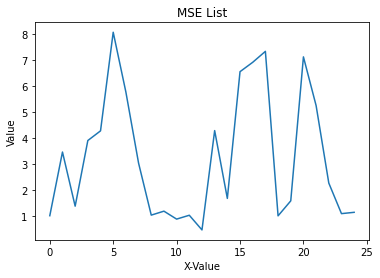

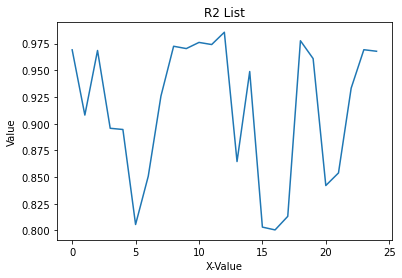

In [ ]:
# plot the values in mse_list
plt.plot(mse_list)
plt.title('MSE List')
plt.xlabel('X-Value')
plt.ylabel('Value')
plt.show()

# plot the values in r2_list
plt.plot(r2_list)
plt.title('R2 List')
plt.xlabel('X-Value')
plt.ylabel('Value')
plt.show()

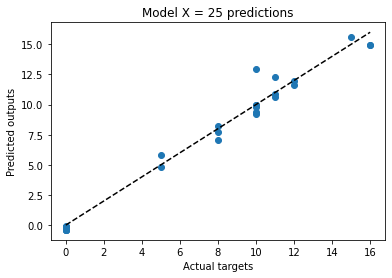

In [ ]:
# Load the saved model for this value of x
model_ = models[12]

# Predict the outputs for the test set
predictions = model_.predict(X_test[12].reshape(-1, 1, 1000))

# Plot best results
plt.figure()
plt.scatter(Y_test[12], predictions)
plt.plot([0, 16], [0, 16], linestyle='--', color='k')  # add a diagonal line y=x
plt.xlabel('Actual targets')
plt.ylabel('Predicted outputs')
plt.title(f'Model X = {x+1} predictions')
plt.show()

# Q2)

In [ ]:
g_params = [0.5, 0.75, 0.85, 0.95, 1, 1.05, 1.15, 1.5, 2]
max_X = 25

inputs_g = []
firingrates_g = []

for i in range(0, len(g_params)):
    sequence_length = 10

    # Set G parameter
    model['g'] = g_params[i]

    # Generate Data
    onehot, input_stream = make_input(sequence_length, model)

    # initialize the firing rates
    firing_rates = np.zeros((model['N'], len(input_stream)))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    for t in range(len(input_stream)-1):
        firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)

    input_stream = np.array(input_stream)
    firing_rates = np.array(firing_rates.T)
    
    inputs_g.append(input_stream)
    firingrates_g.append(firing_rates)

In [ ]:
"""
X_train_g = []
X_test_g = []
Y_train_g = []
Y_test_g = []

for i in range(0, len(g_params)):

    # New data sets for each value of x
    Y_train = []
    X_train = []

    Y_test = []
    X_test = []

    #Split
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firingrates_g[i], inputs_g[i], test_size=0.2, random_state=42)

    # Append the base case (X = 0)
    Y_train.append(Y_train_)
    X_train.append(X_train_)
    Y_test.append(Y_test_)
    X_test.append(X_test_)

    # Restructure data, deleting the first x input sets and last x firing rates sets 
    for x in range(1, max_X):
        # Training data
        input_stream_ = inputs_g[i][x:]
        firing_rates_ = firingrates_g[i][:-(x), :]

        #Split
        X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates_, input_stream_, test_size=0.2, random_state=42)

        Y_train.append(Y_train_)
        X_train.append(X_train_)
        Y_test.append(Y_test_)
        X_test.append(X_test_)
    
    # For all values of g
    X_train_g.append(X_train)
    X_test_g.append(X_test)
    Y_train_g.append(Y_train)
    Y_test_g.append(Y_test)
"""

In [ ]:
"""
# Normalize input data
for i in range(0, len(g_params)):
    for x in range(0, max_X):
        scaler_train = StandardScaler()
        scaler_test = StandardScaler()

        X_train_g[i][x] = scaler_train.fit_transform(X_train_g[i][x])
        X_test_g[i][x] = scaler_test.fit_transform(X_test_g[i][x])
"""

In [ ]:
"""
# Create the "data2" folder if it doesn't exist
if not os.path.exists("data2"):
    os.makedirs("data2")

# Save the variables as pickle files
with open("data2/X_train_g.pickle", "wb") as file:
    pickle.dump(X_train_g, file)

with open("data2/X_test_g.pickle", "wb") as file:
    pickle.dump(X_test_g, file)

with open("data2/Y_train_g.pickle", "wb") as file:
    pickle.dump(Y_train_g, file)

with open("data2/Y_test_g.pickle", "wb") as file:
    pickle.dump(Y_test_g, file)
"""

In [ ]:
# Load the variables from the pickle files
with open("data2/X_train_g.pickle", "rb") as file:
    X_train_g = pickle.load(file)

with open("data2/X_test_g.pickle", "rb") as file:
    X_test_g = pickle.load(file)

with open("data2/Y_train_g.pickle", "rb") as file:
    Y_train_g = pickle.load(file)

with open("data2/Y_test_g.pickle", "rb") as file:
    Y_test_g = pickle.load(file)

In [ ]:
# 2D list of models
models_g = []

for i in range(0, len(g_params)):
    # Create a list to store the models
    models = []

    # Define the EarlyStopping callback
    early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

    # Loop over the range of x values
    for x in range(0, max_X):

        # Define the model architecture
        model_ = Sequential()
        model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))
        model_.add(Dense(1))

        # Add a Dense output layer with a single unit
        model_.add(Dense(1))

        # Compile the model with mean squared error loss
        model_.compile(optimizer='adam', loss='mse')

        # Append the model to the list
        models.append(model_)
    
    # Store list to greater list
    models_g.append(models)

In [ ]:
# Train the models for each value of g
for i in range(0, len(g_params)):

    # Train the models for each value of x
    for x in range(0, max_X):
        # Train the model on the firing rates and targets
        model_ = models_g[i][x]
        model_.fit(X_train_g[i][x].reshape(-1, 1, 1000), Y_train_g[i][x], epochs=100, batch_size=32, callbacks=[early_stop])

        # Create a folder for the models if it doesn't exist
        if not os.path.exists('models2'):
            os.makedirs('models2')

        # Save the model to an HDF5 file in the folder
        filename = f'model_g{i}x{x}.h5'
        model_.save(f'models2/{filename}')


Epoch 1/100
5/5 [==============================] - 2s 3ms/step - loss: 74.9648
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 64.7889
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 61.2866
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 59.5372
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 57.8252
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 55.9352
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 54.5507
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 53.0972
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 51.7066
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 50.3419
Epoch 11/100
1/5 [=====>........................] - ETA: 0s - loss: 26.7893

2023-04-12 13:41:20.855308: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5/5 [==============================] - 0s 4ms/step - loss: 49.0669
Epoch 12/100
5/5 [==============================] - 0s 2ms/step - loss: 48.0097
Epoch 13/100
5/5 [==============================] - 0s 3ms/step - loss: 46.7845
Epoch 14/100
5/5 [==============================] - 0s 3ms/step - loss: 45.7027
Epoch 15/100
5/5 [==============================] - 0s 3ms/step - loss: 44.7263
Epoch 16/100
5/5 [==============================] - 0s 2ms/step - loss: 43.9007
Epoch 17/100
5/5 [==============================] - 0s 2ms/step - loss: 42.9145
Epoch 18/100
5/5 [==============================] - 0s 2ms/step - loss: 42.1927
Epoch 19/100
5/5 [==============================] - 0s 2ms/step - loss: 41.4474
Epoch 20/100
5/5 [==============================] - 0s 2ms/step - loss: 40.8207
Epoch 21/100
5/5 [==============================] - 0s 3ms/step - loss: 40.2458
Epoch 22/100
5/5 [==============================] - 0s 3ms/step - loss: 39.7777
Epoch 23/100
5/5 [==============================] - 0

In [ ]:
# Test Models
mse_list_g = []
r2_list_g = []

# Load the models for each value of g
for i in range(0, len(g_params)):
    mse_list = []
    r2_list = []
    
    for x in range(0, max_X):
        # Load the saved model from the folder
        filename = f'model_g{i}x{x}.h5'
        model_ = load_model(f'models2/{filename}')

        # Test the model on the test set
        predictions = model_.predict(X_test_g[i][x].reshape(-1, 1, 1000))

        # Calculate and print the mean squared error and R-squared for the predictions
        mse = mean_squared_error(Y_test_g[i][x], predictions)
        r2 = r2_score(Y_test_g[i][x], predictions)
        
        mse_list.append(mse)
        r2_list.append(r2)
        
    # Push back each list
    mse_list_g.append(np.array(mse_list))
    r2_list_g.append(np.array(r2_list))
    
# Set whole list to np.arrray
mse_list_g = np.array(mse_list_g)
r2_list_g = np.array(r2_list_g)
        

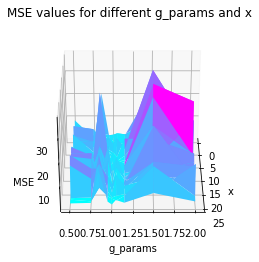

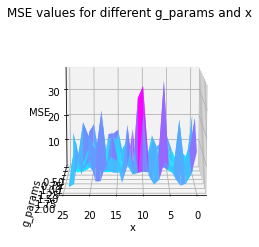

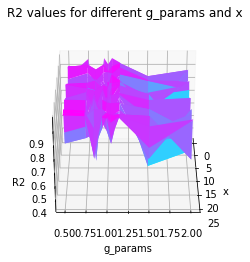

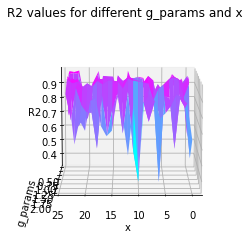

In [ ]:
# Convert the lists to numpy arrays
mse_array = np.array(mse_list_g)
r2_array = np.array(r2_list_g)

# Create a meshgrid for the g_params and x axes
g_params = [0.5, 0.75, 0.85, 0.95, 1, 1.05, 1.15, 1.5, 2]
x_vals = np.arange(0, max_X)
X, Y = np.meshgrid(x_vals, g_params)

# Create the 3D plot for the MSE values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, mse_array, cmap='cool', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('g_params')
ax.set_zlabel('MSE')
ax.set_title('MSE values for different g_params and x')
ax.view_init(elev=30, azim=0)  # Set the viewing angle

# Create the 3D plot for the MSE values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, mse_array, cmap='cool', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('g_params')
ax.set_zlabel('MSE')
ax.set_title('MSE values for different g_params and x')
ax.view_init(elev=10, azim=90)  # Set the viewing angle

# Show the plot
plt.show()

# Create another 3D plot for the R2 values
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X, Y, r2_array, cmap='cool', edgecolor='none')
ax2.set_xlabel('x')
ax2.set_ylabel('g_params')
ax2.set_zlabel('R2')
ax2.set_title('R2 values for different g_params and x')
ax2.view_init(elev=30, azim=0)  # Set the viewing angle

# Create another 3D plot for the R2 values
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X, Y, r2_array, cmap='cool', edgecolor='none')
ax2.set_xlabel('x')
ax2.set_ylabel('g_params')
ax2.set_zlabel('R2')
ax2.set_title('R2 values for different g_params and x')
ax2.view_init(elev=10, azim=90)  # Set the viewing angle

# Show the plot
plt.show()

In [ ]:
# Convert the lists to numpy arrays
mse_array = np.array(mse_list_g)
r2_array = np.array(r2_list_g)

# Find the indices of the minimum MSE and maximum R2 values
min_mse_idx = np.unravel_index(np.argmin(mse_array), mse_array.shape)
max_r2_idx = np.unravel_index(np.argmax(r2_array), r2_array.shape)

# Get the corresponding values of g_params and x
min_mse_g = g_params[min_mse_idx[0]]
min_mse_x = min_mse_idx[1]
min_mse = mse_array[min_mse_idx]

max_r2_g = g_params[max_r2_idx[0]]
max_r2_x = max_r2_idx[1]
max_r2 = r2_array[max_r2_idx]

# Print the results
print(f"Minimum MSE = {min_mse:.4f} at g_params = {min_mse_g} and x = {min_mse_x}")
print(f"Maximum R-squared = {max_r2:.4f} at g_params = {max_r2_g} and x = {max_r2_x}")

Minimum MSE = 0.3872 at g_params = 1.05 and x = 8
Maximum R-squared = 0.9899 at g_params = 1.05 and x = 8


# Q3)

In [ ]:
# Modify input magnitude to be 10
model['nIn'] = 10

# Since modifying input magnitude, have to re-create input weight matrix
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

#keeping all prior conditions set up from Question 1
sequence_length = 10

# Set G parameter
model['g'] = 1

# Generate Data
onehot, input_stream = make_input(sequence_length, model)

# initialize the firing rates
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)
    
input_stream = np.array(input_stream)
firing_rates = np.array(firing_rates.T)

In [ ]:
print(input_stream.shape)
print(firing_rates.shape)

(200,)
(200, 1000)


In [ ]:
# Determin X value and restructure data accordingly
max_X = 25

# New data sets for each value of x
Y_train = []
X_train = []

Y_test = []
X_test = []

#Split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates, input_stream, test_size=0.2, random_state=42)

# Append the base case (X = 0)
Y_train.append(Y_train_)
X_train.append(X_train_)
Y_test.append(Y_test_)
X_test.append(X_test_)

# Restructure data, deleting the first x input sets and last x firing rates sets 
for x in range(1, max_X):
    # Training data
    input_stream_ = input_stream[x:]
    firing_rates_ = firing_rates[:-(x), :]
    
    #Split
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates_, input_stream_, test_size=0.2, random_state=42)

    Y_train.append(Y_train_)
    X_train.append(X_train_)
    Y_test.append(Y_test_)
    X_test.append(X_test_)

In [ ]:
# Useful shapes to consider, (size-x, 1000)
print(Y_train[0].shape)
print(X_train[0].shape)
print(Y_test[0].shape)
print(X_test[0].shape)

(160,)
(160, 1000)
(40,)
(40, 1000)


In [ ]:
# Normalize input data
for x in range(0, max_X):
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()

    X_train[x] = scaler_train.fit_transform(X_train[x])
    X_test[x] = scaler_test.fit_transform(X_test[x])

In [ ]:
# Create a list to store the models
models = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

# Loop over the range of x values
for x in range(0, max_X):
    
    # Define the model architecture
    model_ = Sequential()
    model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))
    model_.add(Dense(1))

    # Add a Dense output layer with a single unit
    model_.add(Dense(1))

    # Compile the model with mean squared error loss
    model_.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models.append(model_)

In [ ]:
X_train[x].reshape(1, -1, 1000).shape

(1, 140, 1000)

In [ ]:
# Train the models for each value of x
for x in range(0, max_X):
    # Train the model on the firing rates and targets
    model_ = models[x]
    model_.fit(X_train[x].reshape(-1, 1, 1000), Y_train[x], epochs=100, batch_size=32, callbacks=[early_stop])

    # Create a folder for the models if it doesn't exist
    if not os.path.exists('models1'):
        os.makedirs('models1')

    # Save the model to an HDF5 file in the folder
    filename = f'model_{x}.h5'
    model_.save(f'models3/{filename}')

Epoch 1/100
5/5 [==============================] - 1s 6ms/step - loss: 17.0754
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 4.6359
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 3.7287
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 1.8566
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 1.9609
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 1.2626
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 1.2103
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.9293
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 0.8538
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.8154
Epoch 11/100
5/5 [==============================] - 0s 5ms/step - loss: 0.7598
Epoch 12/100
5/5 [==============================] - 0s 5ms/step - loss: 0.7110
Epoch 13/100
5/5 [==============================] - 0s 5ms/s

In [ ]:
mse_list = []
r2_list = []

# Test the models for each value of x
for x in range(0, max_X):
    # Load the saved model for this value of x
    model_ = models[x]

    # Predict the outputs for the test set
    predictions = model_.predict(X_test[x].reshape(-1, 1, 1000))

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(Y_test[x], predictions)
    r2 = r2_score(Y_test[x], predictions)
    print(f'Model {x}: MSE = {mse:.4f}, R-squared = {r2:.4f}')
    
    mse_list.append(mse)
    r2_list.append(r2)

2/2 [==============================] - 0s 11ms/step
Model 0: MSE = 0.6488, R-squared = 0.9374
2/2 [==============================] - 0s 8ms/step
Model 1: MSE = 1.3044, R-squared = 0.8526
2/2 [==============================] - 0s 9ms/step
Model 2: MSE = 0.6203, R-squared = 0.9436
2/2 [==============================] - 0s 9ms/step
Model 3: MSE = 0.2810, R-squared = 0.9758
2/2 [==============================] - 0s 8ms/step
Model 4: MSE = 0.5950, R-squared = 0.9469
2/2 [==============================] - 0s 8ms/step
Model 5: MSE = 1.2993, R-squared = 0.8662
2/2 [==============================] - 0s 23ms/step
Model 6: MSE = 1.0972, R-squared = 0.8908
2/2 [==============================] - 0s 8ms/step
Model 7: MSE = 1.2609, R-squared = 0.9026
2/2 [==============================] - 0s 11ms/step
Model 8: MSE = 0.6052, R-squared = 0.9509
2/2 [==============================] - 1s 11ms/step
Model 9: MSE = 0.6679, R-squared = 0.9233
2/2 [==============================] - 0s 5ms/step
Model 10: MSE =

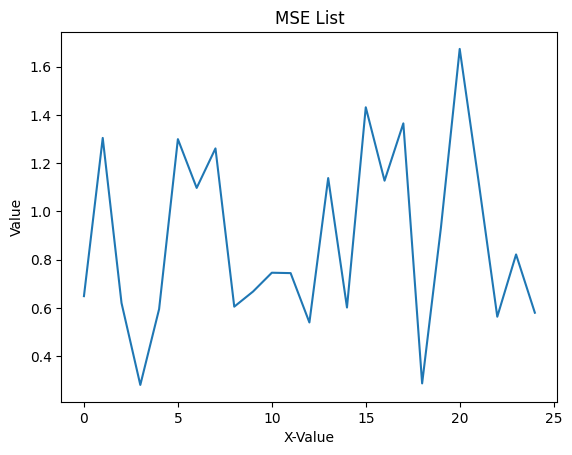

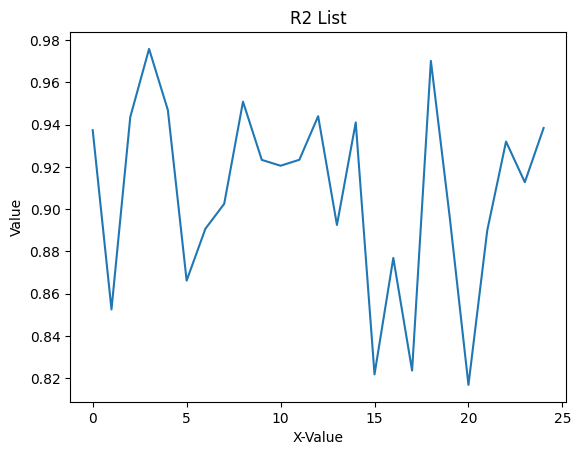

In [ ]:
# plot the values in mse_list
plt.plot(mse_list)
plt.title('MSE List')
plt.xlabel('X-Value')
plt.ylabel('Value')
plt.show()

# plot the values in r2_list
plt.plot(r2_list)
plt.title('R2 List')
plt.xlabel('X-Value')
plt.ylabel('Value')
plt.show()

2/2 [==============================] - 0s 8ms/step


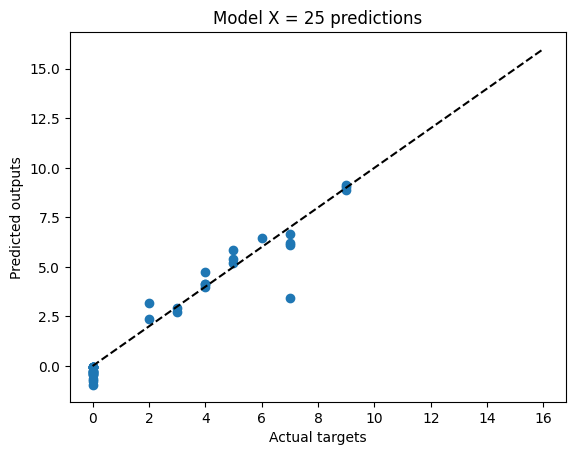

In [ ]:
# Load the saved model for this value of x
model_ = models[12]

# Predict the outputs for the test set
predictions = model_.predict(X_test[12].reshape(-1, 1, 1000))

# Plot best results
plt.figure()
plt.scatter(Y_test[12], predictions)
plt.plot([0, 16], [0, 16], linestyle='--', color='k')  # add a diagonal line y=x
plt.xlabel('Actual targets')
plt.ylabel('Predicted outputs')
plt.title(f'Model X = {x+1} predictions')
plt.show()

In [ ]:
# Modify input magnitude to be 30
model['nIn'] = 30

# Since modifying input magnitude, have to re-create input weight matrix
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

#keeping all prior conditions set up from Question 1
sequence_length = 10

# Set G parameter
model['g'] = 1

# Generate Data
onehot, input_stream = make_input(sequence_length, model)

# initialize the firing rates
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)
    
input_stream = np.array(input_stream)
firing_rates = np.array(firing_rates.T)

In [ ]:
print(input_stream.shape)
print(firing_rates.shape)

(200,)
(200, 1000)


In [ ]:
# Determin X value and restructure data accordingly
max_X = 25

# New data sets for each value of x
Y_train = []
X_train = []

Y_test = []
X_test = []

#Split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates, input_stream, test_size=0.2, random_state=42)

# Append the base case (X = 0)
Y_train.append(Y_train_)
X_train.append(X_train_)
Y_test.append(Y_test_)
X_test.append(X_test_)

# Restructure data, deleting the first x input sets and last x firing rates sets 
for x in range(1, max_X):
    # Training data
    input_stream_ = input_stream[x:]
    firing_rates_ = firing_rates[:-(x), :]
    
    #Split
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates_, input_stream_, test_size=0.2, random_state=42)

    Y_train.append(Y_train_)
    X_train.append(X_train_)
    Y_test.append(Y_test_)
    X_test.append(X_test_)

In [ ]:
# Useful shapes to consider, (size-x, 1000)
print(Y_train[0].shape)
print(X_train[0].shape)
print(Y_test[0].shape)
print(X_test[0].shape)

(160,)
(160, 1000)
(40,)
(40, 1000)


In [ ]:
# Normalize input data
for x in range(0, max_X):
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()

    X_train[x] = scaler_train.fit_transform(X_train[x])
    X_test[x] = scaler_test.fit_transform(X_test[x])

In [ ]:
# Create a list to store the models
models = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

# Loop over the range of x values
for x in range(0, max_X):
    
    # Define the model architecture
    model_ = Sequential()
    model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))
    model_.add(Dense(1))

    # Add a Dense output layer with a single unit
    model_.add(Dense(1))

    # Compile the model with mean squared error loss
    model_.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models.append(model_)

In [ ]:
X_train[x].reshape(1, -1, 1000).shape

(1, 140, 1000)

In [ ]:
# Train the models for each value of x
for x in range(0, max_X):
    # Train the model on the firing rates and targets
    model_ = models[x]
    model_.fit(X_train[x].reshape(-1, 1, 1000), Y_train[x], epochs=100, batch_size=32, callbacks=[early_stop])

    # Create a folder for the models if it doesn't exist
    if not os.path.exists('models1'):
        os.makedirs('models1')

    # Save the model to an HDF5 file in the folder
    filename = f'model_{x}.h5'
    model_.save(f'models3/{filename}')

Epoch 1/100
5/5 [==============================] - 3s 10ms/step - loss: 115.1527
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 59.2597
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 48.1010
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 39.1742
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 33.6002
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 29.5778
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 26.6167
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 24.1203
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 21.9713
Epoch 10/100
5/5 [==============================] - 0s 16ms/step - loss: 20.4223
Epoch 11/100
5/5 [==============================] - 0s 10ms/step - loss: 18.3120
Epoch 12/100
5/5 [==============================] - 0s 9ms/step - loss: 17.5990
Epoch 13/100
5/5 [=====================

In [ ]:
mse_list = []
r2_list = []

# Test the models for each value of x
for x in range(0, max_X):
    # Load the saved model for this value of x
    model_ = models[x]

    # Predict the outputs for the test set
    predictions = model_.predict(X_test[x].reshape(-1, 1, 1000))

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(Y_test[x], predictions)
    r2 = r2_score(Y_test[x], predictions)
    print(f'Model {x}: MSE = {mse:.4f}, R-squared = {r2:.4f}')
    
    mse_list.append(mse)
    r2_list.append(r2)

2/2 [==============================] - 0s 5ms/step
Model 0: MSE = 5.2546, R-squared = 0.9425
2/2 [==============================] - 0s 6ms/step
Model 1: MSE = 17.9943, R-squared = 0.8235
2/2 [==============================] - 0s 5ms/step
Model 2: MSE = 3.8524, R-squared = 0.9636
2/2 [==============================] - 0s 5ms/step
Model 3: MSE = 7.1172, R-squared = 0.9305
2/2 [==============================] - 0s 5ms/step
Model 4: MSE = 12.9949, R-squared = 0.8820
2/2 [==============================] - 0s 6ms/step
Model 5: MSE = 19.0838, R-squared = 0.8435
2/2 [==============================] - 0s 6ms/step
Model 6: MSE = 19.8283, R-squared = 0.8251
2/2 [==============================] - 0s 6ms/step
Model 7: MSE = 13.3476, R-squared = 0.8729
2/2 [==============================] - 0s 6ms/step
Model 8: MSE = 13.7474, R-squared = 0.8748
2/2 [==============================] - 0s 4ms/step
Model 9: MSE = 5.3437, R-squared = 0.9473
2/2 [==============================] - 0s 4ms/step
Model 10: MSE

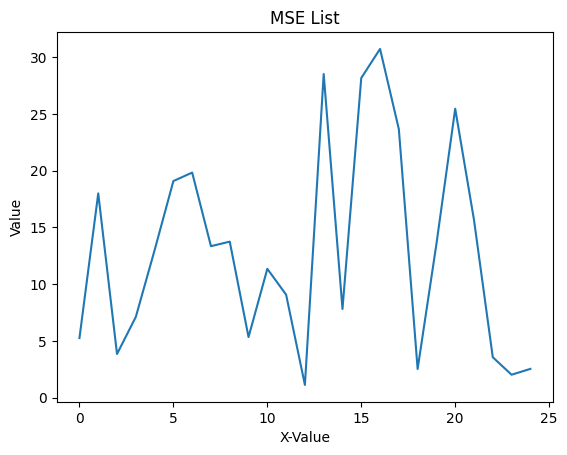

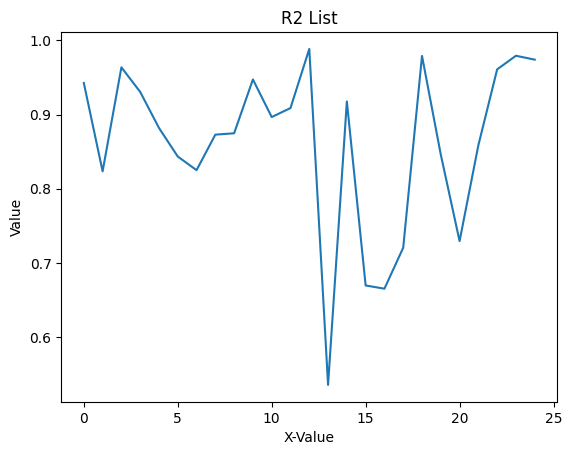

In [ ]:
# plot the values in mse_list
plt.plot(mse_list)
plt.title('MSE List')
plt.xlabel('X-Value')
plt.ylabel('Value')
plt.show()

# plot the values in r2_list
plt.plot(r2_list)
plt.title('R2 List')
plt.xlabel('X-Value')
plt.ylabel('Value')
plt.show()

2/2 [==============================] - 0s 8ms/step


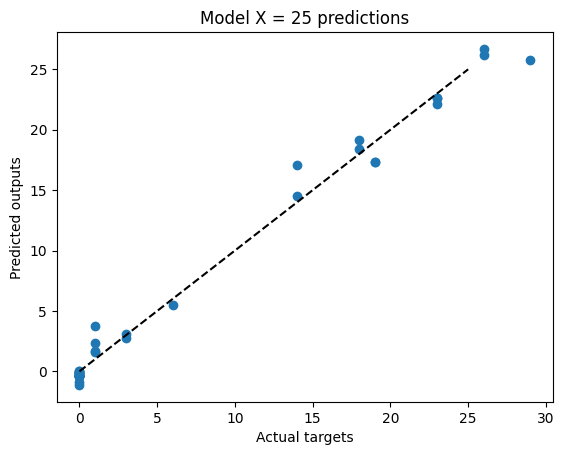

In [ ]:
# Load the saved model for this value of x
model_ = models[12]

# Predict the outputs for the test set
predictions = model_.predict(X_test[12].reshape(-1, 1, 1000))

# Plot best results
plt.figure()
plt.scatter(Y_test[12], predictions)
plt.plot([0, 25], [0, 25], linestyle='--', color='k')  # add a diagonal line y=x
plt.xlabel('Actual targets')
plt.ylabel('Predicted outputs')
plt.title(f'Model X = {x+1} predictions')
plt.show()

In [ ]:
Nin_params = [10, 20, 30, 40, 50, 60, 70, 80, 90]
max_X = 25

inputs_Nin = []
firingrates_Nin = []

for i in range(0, len(Nin_params)):
    sequence_length = 10

    # Set Nin parameter
    model['Nin'] = Nin_params[i]

    # Since modifying input magnitude, have to re-create input weight matrix
    randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
    spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
    model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

    # Set G parameter
    model['g'] = 1.05

    # Generate Data
    onehot, input_stream = make_input(sequence_length, model)

    # initialize the firing rates
    firing_rates = np.zeros((model['N'], len(input_stream)))
    firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

    for t in range(len(input_stream)-1):
        firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)

    input_stream = np.array(input_stream)
    firing_rates = np.array(firing_rates.T)
    
    inputs_Nin.append(input_stream)
    firingrates_Nin.append(firing_rates)

In [ ]:
# Determin X value and restructure data accordingly
max_X = 25

# New data sets for each value of x
Y_train = []
X_train = []

Y_test = []
X_test = []

#Split
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates, input_stream, test_size=0.2, random_state=42)

# Append the base case (X = 0)
Y_train.append(Y_train_)
X_train.append(X_train_)
Y_test.append(Y_test_)
X_test.append(X_test_)

# Restructure data, deleting the first x input sets and last x firing rates sets 
for x in range(1, max_X):
    # Training data
    input_stream_ = input_stream[x:]
    firing_rates_ = firing_rates[:-(x), :]
    
    #Split
    X_train_, X_test_, Y_train_, Y_test_ = train_test_split(firing_rates_, input_stream_, test_size=0.2, random_state=42)

    Y_train.append(Y_train_)
    X_train.append(X_train_)
    Y_test.append(Y_test_)
    X_test.append(X_test_)

In [ ]:
# Normalize input data
for x in range(0, max_X):
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()

    X_train[x] = scaler_train.fit_transform(X_train[x])
    X_test[x] = scaler_test.fit_transform(X_test[x])

In [ ]:
# 2D list of models
models_Nin = []

for i in range(0, len(Nin_params)):
    # Create a list to store the models
    models = []

    # Define the EarlyStopping callback
    early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

    # Loop over the range of x values
    for x in range(0, max_X):

        # Define the model architecture
        model_ = Sequential()
        model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))
        model_.add(Dense(1))

        # Add a Dense output layer with a single unit
        model_.add(Dense(1))

        # Compile the model with mean squared error loss
        model_.compile(optimizer='adam', loss='mse')

        # Append the model to the list
        models.append(model_)
    
    # Store list to greater list
    models_Nin.append(models)

In [ ]:
# Train the models for each value of Nin
for i in range(0, len(Nin_params)):

    # Train the models for each value of x
    for x in range(0, max_X):
        # Train the model on the firing rates and targets
        model_ = models_Nin[i][x]
        model_.fit(X_train[x].reshape(-1, 1, 1000), Y_train[x], epochs=100, batch_size=32, callbacks=[early_stop])

        # Create a folder for the models if it doesn't exist
        if not os.path.exists('models3'):
            os.makedirs('models3')

        # Save the model to an HDF5 file in the folder
        filename = f'model_Nin{i}x{x}.h5'
        model_.save(f'models3/{filename}')

Streaming output truncated to the last 5000 lines.
Epoch 41/100
5/5 [==============================] - 0s 8ms/step - loss: 93.3591
Epoch 42/100
5/5 [==============================] - 0s 9ms/step - loss: 92.7369
Epoch 43/100
5/5 [==============================] - 0s 8ms/step - loss: 92.1435
Epoch 44/100
5/5 [==============================] - 0s 8ms/step - loss: 92.0437
Epoch 45/100
5/5 [==============================] - 0s 8ms/step - loss: 91.9473
Epoch 46/100
5/5 [==============================] - 0s 8ms/step - loss: 90.8014
Epoch 47/100
5/5 [==============================] - 0s 7ms/step - loss: 89.9663
Epoch 48/100
5/5 [==============================] - 0s 7ms/step - loss: 89.4264
Epoch 49/100
5/5 [==============================] - 0s 7ms/step - loss: 89.0515
Epoch 50/100
5/5 [==============================] - 0s 8ms/step - loss: 88.5546
Epoch 51/100
5/5 [==============================] - 0s 10ms/step - loss: 87.7649
Epoch 52/100
5/5 [==============================] - 0s 8ms/step - lo

In [ ]:
# Test Models
mse_list_Nin = []
r2_list_Nin = []

# Load the models for each value of g
for i in range(0, len(g_params)):
    mse_list = []
    r2_list = []
    
    for x in range(0, max_X):
        # Load the saved model from the folder
        filename = f'model_Nin{i}x{x}.h5'
        model_ = load_model(f'models3/{filename}')

        # Test the model on the test set
        predictions = model_.predict(X_test[x].reshape(-1, 1, 1000))

        # Calculate and print the mean squared error and R-squared for the predictions
        mse = mean_squared_error(Y_test[x], predictions)
        r2 = r2_score(Y_test[x], predictions)
        
        mse_list.append(mse)
        r2_list.append(r2)
        
    # Push back each list
    mse_list_Nin.append(np.array(mse_list))
    r2_list_Nin.append(np.array(r2_list))
    
# Set whole list to np.arrray
mse_list_Nin = np.array(mse_list_Nin)
r2_list_Nin = np.array(r2_list_Nin)
        

2/2 [==============================] - 0s 8ms/step


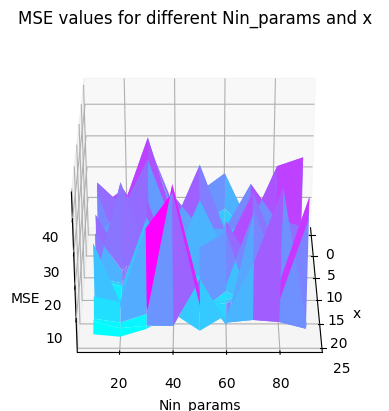

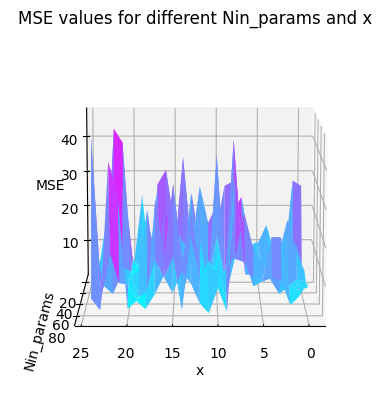

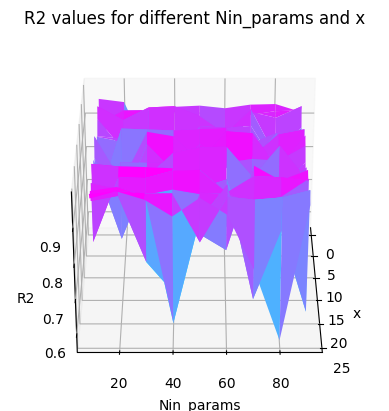

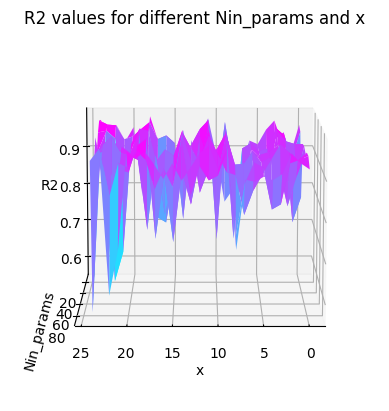

In [ ]:
# Convert the lists to numpy arrays
mse_array = np.array(mse_list_Nin)
r2_array = np.array(r2_list_Nin)

# Create a meshgrid for the g_params and x axes
Nin_params = [10, 20, 30, 40, 50, 60, 70, 80, 90]
x_vals = np.arange(0, max_X)
X, Y = np.meshgrid(x_vals, Nin_params)

# Create the 3D plot for the MSE values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, mse_array, cmap='cool', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('Nin_params')
ax.set_zlabel('MSE')
ax.set_title('MSE values for different Nin_params and x')
ax.view_init(elev=30, azim=0)  # Set the viewing angle

# Create the 3D plot for the MSE values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, mse_array, cmap='cool', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('Nin_params')
ax.set_zlabel('MSE')
ax.set_title('MSE values for different Nin_params and x')
ax.view_init(elev=10, azim=90)  # Set the viewing angle

# Show the plot
plt.show()

# Create another 3D plot for the R2 values
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X, Y, r2_array, cmap='cool', edgecolor='none')
ax2.set_xlabel('x')
ax2.set_ylabel('Nin_params')
ax2.set_zlabel('R2')
ax2.set_title('R2 values for different Nin_params and x')
ax2.view_init(elev=30, azim=0)  # Set the viewing angle

# Create another 3D plot for the R2 values
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X, Y, r2_array, cmap='cool', edgecolor='none')
ax2.set_xlabel('x')
ax2.set_ylabel('Nin_params')
ax2.set_zlabel('R2')
ax2.set_title('R2 values for different Nin_params and x')
ax2.view_init(elev=10, azim=90)  # Set the viewing angle

# Show the plot
plt.show()

In [ ]:
# Convert the lists to numpy arrays
mse_array = np.array(mse_list_Nin)
r2_array = np.array(r2_list_Nin)

# Find the indices of the minimum MSE and maximum R2 values
min_mse_idx = np.unravel_index(np.argmin(mse_array), mse_array.shape)
max_r2_idx = np.unravel_index(np.argmax(r2_array), r2_array.shape)

# Get the corresponding values of g_params and x
min_mse_Nin = Nin_params[min_mse_idx[0]]
min_mse_x = min_mse_idx[1]
min_mse = mse_array[min_mse_idx]

max_r2_Nin = Nin_params[max_r2_idx[0]]
max_r2_x = max_r2_idx[1]
max_r2 = r2_array[max_r2_idx]

# Print the results
print(f"Minimum MSE = {min_mse:.4f} at Nin_params = {min_mse_Nin} and x = {min_mse_x}")
print(f"Maximum R-squared = {max_r2:.4f} at Nin_params = {max_r2_Nin} and x = {max_r2_x}")

Minimum MSE = 0.8389 at Nin_params = 60 and x = 11
Maximum R-squared = 0.9925 at Nin_params = 60 and x = 11


# Q4)

# Q5)

In [40]:
sequence_length = 10

# Set G parameter
model['g'] = 1.05

# Generate Data
onehot, input_stream = make_input(sequence_length, model)

# initialize the firing rates
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)
    
input_stream = np.array(input_stream)
firing_rates = np.array(firing_rates.T)
onehot = np.array(onehot.T)

In [41]:
# Useful Shapes
print(input_stream.shape)
print(firing_rates.shape)
print(onehot.shape)

(200,)
(200, 1000)
(200, 20)


In [67]:
# Determin X value and restructure data accordingly
max_X = 20

# New data sets for each value of x
Y_train_mag = []
Y_train_one = []
X_train_mag = []
X_train_one = []

Y_test_mag = []
Y_test_one = []
X_test_mag = []
X_test_one = []

#Split
X_train_mag_, X_test_mag_, Y_train_mag_, Y_test_mag_ = train_test_split(firing_rates, input_stream, test_size=0.2, random_state=42)
X_train_one_, X_test_one_, Y_train_one_, Y_test_one_ = train_test_split(firing_rates, onehot, test_size=0.2, random_state=42)

# Append the base case (X = 0)
Y_train_mag.append(Y_train_mag_)
X_train_mag.append(X_train_mag_)
Y_test_mag.append(Y_test_mag_)
X_test_mag.append(X_test_mag_)

Y_train_one.append(Y_train_one_)
X_train_one.append(X_train_one_)
Y_test_one.append(Y_test_one_)
X_test_one.append(X_test_one_)

# Restructure data, deleting the first x input sets and last x firing rates sets 
for x in range(1, max_X):
  # Training data
  input_stream_ = input_stream[x:]
  firing_rates_ = firing_rates[:-(x), :]
  onehot_ = onehot[x:]
    
  #Split
  X_train_mag_, X_test_mag_, Y_train_mag_, Y_test_mag_ = train_test_split(firing_rates_, input_stream_, test_size=0.2, random_state=42)
  X_train_one_, X_test_one_, Y_train_one_, Y_test_one_ = train_test_split(firing_rates_, onehot_, test_size=0.2, random_state=42)

  Y_train_mag.append(Y_train_mag_)
  X_train_mag.append(X_train_mag_)
  Y_test_mag.append(Y_test_mag_)
  X_test_mag.append(X_test_mag_)

  Y_train_one.append(Y_train_one_)
  X_train_one.append(X_train_one_)
  Y_test_one.append(Y_test_one_)
  X_test_one.append(X_test_one_)

In [68]:
# New Input Shape for onehot
print(Y_train_one[0].shape)

(160, 20)


In [69]:
# Normalize input data just for the variable magnitude input stream
for x in range(0, max_X):
    scaler_train_mag = StandardScaler()
    scaler_test_mag = StandardScaler()

    X_train_mag[x] = scaler_train_mag.fit_transform(X_train_mag[x])
    X_test_mag[x] = scaler_test_mag.fit_transform(X_test_mag[x])

In [70]:
# Create a list to store the models
models_mag = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

# Loop over the range of x values
for x in range(0, max_X):
    
    # Define the model architecture
    model_ = Sequential()
    model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))

    # Add a Dense output layer with a single unit
    model_.add(Dense(1))

    # Compile the model with mean squared error loss
    model_.compile(optimizer='adam', loss='mse')
    
    # Append the model to the list
    models_mag.append(model_)

In [71]:
# Train the models for each value of x
for x in range(0, max_X):
    # Train the model on the firing rates and targets
    model_ = models_mag[x]
    model_.fit(X_train_mag[x].reshape(-1, 1, 1000), Y_train_mag[x], epochs=100, batch_size=32, callbacks=[early_stop])

    # Create a folder for the models if it doesn't exist
    if not os.path.exists('models5_mag'):
        os.makedirs('models5_mag')

    # Save the model to an HDF5 file in the folder
    filename = f'model_mag{x}.h5'
    model_.save(f'models5_mag/{filename}')


Epoch 1/100
5/5 [==============================] - 1s 7ms/step - loss: 60.2448
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 37.7115
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 29.8971
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 26.2252
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 23.2963
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 20.7132
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 18.6268
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 17.1541
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 15.3188
Epoch 10/100
5/5 [==============================] - 0s 6ms/step - loss: 13.9937
Epoch 11/100
5/5 [==============================] - 0s 6ms/step - loss: 12.9879
Epoch 12/100
5/5 [==============================] - 0s 6ms/step - loss: 12.0826
Epoch 13/100
5/5 [==============================]

In [73]:
# Create a list to store the models
models_one = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

# Loop over the range of x values
for x in range(0, max_X):
    
    # Define the model architecture
    model_ = Sequential()
    model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))

    # Add a Dense output layer with a single unit
    model_.add(Dense(20, activation='softmax'))

    # Compile the model with mean squared error loss
    model_.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Append the model to the list
    models_one.append(model_)

In [74]:
# Train the models for each value of x
for x in range(0, max_X):
    # Train the model on the firing rates and targets
    model_ = models_one[x]
    model_.fit(X_train_one[x].reshape(-1, 1, 1000), Y_train_one[x], epochs=100, batch_size=32, callbacks=[early_stop])

    # Create a folder for the models if it doesn't exist
    if not os.path.exists('models5_one'):
        os.makedirs('models5_one')

    # Save the model to an HDF5 file in the folder
    filename = f'model_one{x}.h5'
    model_.save(f'models5_one/{filename}')


Epoch 1/100
5/5 [==============================] - 1s 7ms/step - loss: 0.5979 - accuracy: 0.0812
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 0.3973 - accuracy: 0.1375
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.2532 - accuracy: 0.1562
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1663 - accuracy: 0.1750
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.1244 - accuracy: 0.1750
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1035 - accuracy: 0.1813
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0928 - accuracy: 0.2125
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0851 - accuracy: 0.2375
Epoch 9/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0795 - accuracy: 0.2750
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0752 - accuracy: 0.3000
Epoch 11/100
5/5 [===========

In [75]:
mse_list_mag = []
r2_list_mag = []

# Test the models for each value of x
for x in range(0, max_X):
    # Load the saved model for this value of x
    model_ = models_mag[x]

    # Predict the outputs for the test set
    predictions = model_.predict(X_test_mag[x].reshape(-1, 1, 1000))

    # Calculate and print the mean squared error and R-squared for the predictions
    mse = mean_squared_error(Y_test_mag[x], predictions)
    r2 = r2_score(Y_test_mag[x], predictions)
    print(f'Model {x}: MSE = {mse:.4f}, R-squared = {r2:.4f}')
    
    mse_list_mag.append(mse)
    r2_list_mag.append(r2)

2/2 [==============================] - 0s 13ms/step
Model 0: MSE = 6.2647, R-squared = 0.8802
2/2 [==============================] - 0s 8ms/step
Model 1: MSE = 6.1328, R-squared = 0.8802
2/2 [==============================] - 0s 12ms/step
Model 2: MSE = 2.6029, R-squared = 0.9494
2/2 [==============================] - 0s 12ms/step
Model 3: MSE = 1.9362, R-squared = 0.9526
2/2 [==============================] - 0s 5ms/step
Model 4: MSE = 3.9178, R-squared = 0.9028
2/2 [==============================] - 0s 6ms/step
Model 5: MSE = 8.9125, R-squared = 0.8330
2/2 [==============================] - 0s 8ms/step
Model 6: MSE = 9.6201, R-squared = 0.8187
2/2 [==============================] - 0s 10ms/step
Model 7: MSE = 18.6978, R-squared = 0.6894
2/2 [==============================] - 0s 6ms/step
Model 8: MSE = 12.7254, R-squared = 0.7778
2/2 [==============================] - 0s 6ms/step
Model 9: MSE = 2.4084, R-squared = 0.9565
2/2 [==============================] - 0s 8ms/step
Model 10: MSE

In [78]:
accuracy_list_one = []
f1_score_list_one = []

# Test the models for each value of x
for x in range(0, max_X):
    # Load the saved model for this value of x
    model_ = models_one[x]

    # Predict the outputs for the test set
    predictions = model_.predict(X_test_one[x].reshape(-1, 1, 1000))

    # Calculate and print the accuracy and F1-score for the predictions
    accuracy = accuracy_score(Y_test_one[x], np.round(predictions))
    f1 = f1_score(Y_test_one[x], np.round(predictions), average='macro')
    print(f'Model {x}: Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}')
    
    accuracy_list_one.append(accuracy)
    f1_score_list_one.append(f1)

2/2 [==============================] - 0s 7ms/step
Model 0: Accuracy = 0.5250, F1-score = 0.2825


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 1: Accuracy = 0.3000, F1-score = 0.1480


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 2: Accuracy = 0.4000, F1-score = 0.2040


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 6ms/step
Model 3: Accuracy = 0.4000, F1-score = 0.2927


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 5ms/step
Model 4: Accuracy = 0.4750, F1-score = 0.2719


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 9ms/step
Model 5: Accuracy = 0.4872, F1-score = 0.2694


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 6ms/step
Model 6: Accuracy = 0.4872, F1-score = 0.2590


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 7: Accuracy = 0.5897, F1-score = 0.2020


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 10ms/step
Model 8: Accuracy = 0.4872, F1-score = 0.2186


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 9: Accuracy = 0.4872, F1-score = 0.2379


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 5ms/step
Model 10: Accuracy = 0.6053, F1-score = 0.2534


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 6ms/step
Model 11: Accuracy = 0.4474, F1-score = 0.2567


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 16ms/step
Model 12: Accuracy = 0.4737, F1-score = 0.3520


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 9ms/step
Model 13: Accuracy = 0.6053, F1-score = 0.2700


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 11ms/step
Model 14: Accuracy = 0.5789, F1-score = 0.2882


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 15: Accuracy = 0.5946, F1-score = 0.3211


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 16: Accuracy = 0.3784, F1-score = 0.2980


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 17: Accuracy = 0.4054, F1-score = 0.2543


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 10ms/step
Model 18: Accuracy = 0.5405, F1-score = 0.2400


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 19: Accuracy = 0.5676, F1-score = 0.2952


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


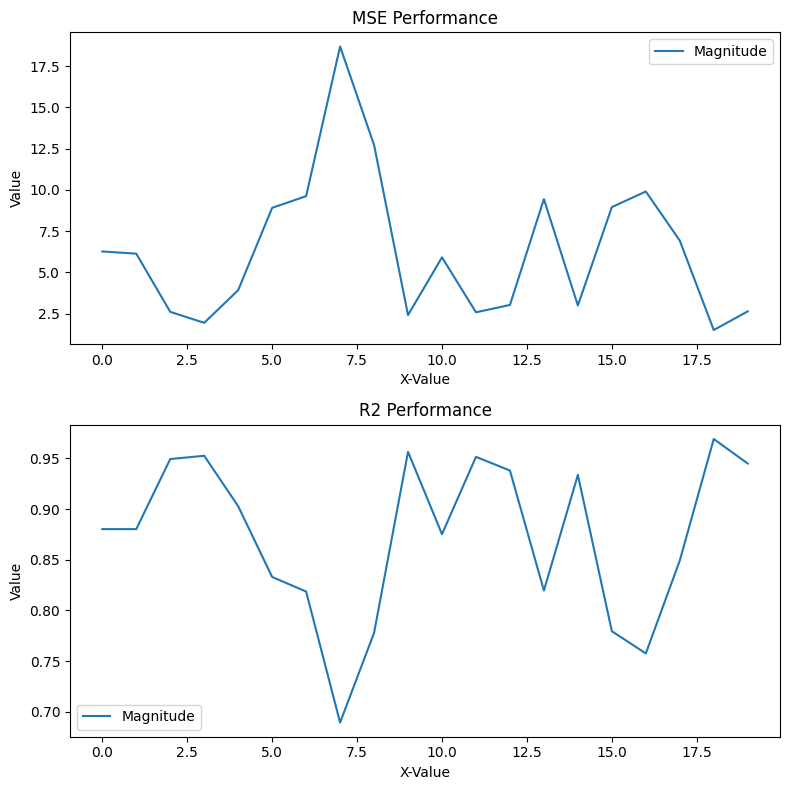

In [79]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot the values in mse_list_mag and mse_list_one in the first subplot
axs[0].plot(mse_list_mag, label='Magnitude')
axs[0].set_title('MSE Performance')
axs[0].set_xlabel('X-Value')
axs[0].set_ylabel('Value')
axs[0].legend()

# Plot the values in r2_list_mag and r2_list_one in the second subplot
axs[1].plot(r2_list_mag, label='Magnitude')
axs[1].set_title('R2 Performance')
axs[1].set_xlabel('X-Value')
axs[1].set_ylabel('Value')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

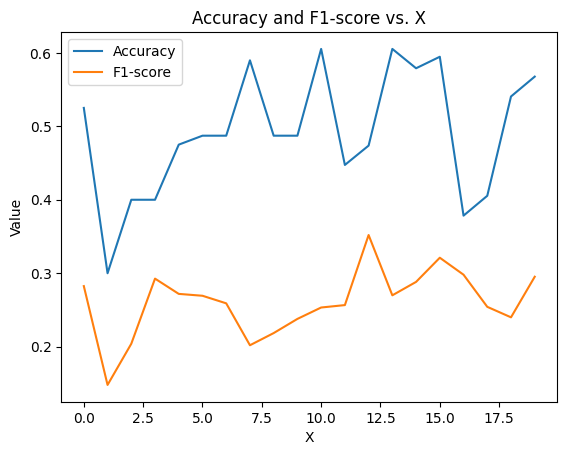

In [80]:
# Plot the accuracy and F1-score for each value of x
plt.plot(range(0, max_X), accuracy_list_one, label='Accuracy')
plt.plot(range(0, max_X), f1_score_list_one, label='F1-score')
plt.title('Accuracy and F1-score vs. X')
plt.xlabel('X')
plt.ylabel('Value')
plt.legend()
plt.show()

In [81]:
# Find the maximum F1-score and the corresponding value of X
best_f1_score = max(f1_score_list_one)
best_x = f1_score_list_one.index(best_f1_score)
print(f'Best result: X = {best_x}, F1-score = {best_f1_score:.4f}')

Best result: X = 12, F1-score = 0.3520


## Stress Testing Model)
* Has less epochs
* Focused on finding which x value causes the model to break down
* Increasing sequence length

In [91]:
sequence_length = 100

# Set G parameter
model['g'] = 1.05

# Generate Data
onehot, input_stream = make_input(sequence_length, model)

# initialize the firing rates
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
    firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)
    
input_stream = np.array(input_stream)
firing_rates = np.array(firing_rates.T)
onehot = np.array(onehot.T)

In [92]:
# Useful Shapes
print(input_stream.shape)
print(firing_rates.shape)
print(onehot.shape)

(1100,)
(1100, 1000)
(1100, 20)


In [93]:
# Determin X value and restructure data accordingly
max_X = 100

# New data sets for each value of x
Y_train_one = []
X_train_one = []

Y_test_one = []
X_test_one = []

#Split
X_train_one_, X_test_one_, Y_train_one_, Y_test_one_ = train_test_split(firing_rates, onehot, test_size=0.2, random_state=42)

# Append the base case (X = 0)
Y_train_one.append(Y_train_one_)
X_train_one.append(X_train_one_)
Y_test_one.append(Y_test_one_)
X_test_one.append(X_test_one_)

# Restructure data, deleting the first x input sets and last x firing rates sets 
for x in range(1, max_X):
  # Training data
  firing_rates_ = firing_rates[:-(x*10), :]
  onehot_ = onehot[(x*10):]
    
  #Split
  X_train_one_, X_test_one_, Y_train_one_, Y_test_one_ = train_test_split(firing_rates_, onehot_, test_size=0.2, random_state=42)

  Y_train_one.append(Y_train_one_)
  X_train_one.append(X_train_one_)
  Y_test_one.append(Y_test_one_)
  X_test_one.append(X_test_one_)

In [94]:
# Create a list to store the models
models_one = []

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

# Loop over the range of x values
for x in range(0, max_X):
    
    # Define the model architecture
    model_ = Sequential()
    model_.add(SimpleRNN(128, input_shape=(None, 1000), recurrent_initializer='glorot_uniform'))

    # Add a Dense output layer with a single unit
    model_.add(Dense(20, activation='softmax'))

    # Compile the model with mean squared error loss
    model_.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Append the model to the list
    models_one.append(model_)

In [95]:
# Train the models for each value of x
for x in range(0, max_X):
    # Train the model on the firing rates and targets
    model_ = models_one[x]
    model_.fit(X_train_one[x].reshape(-1, 1, 1000), Y_train_one[x], epochs=50, batch_size=128, callbacks=[early_stop])


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 1s 13ms/step - loss: 0.5713 - accuracy: 0.0646
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3818 - accuracy: 0.0938
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 0.2850 - accuracy: 0.1208
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.2376 - accuracy: 0.1396
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.2133 - accuracy: 0.2021
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 0.2001 - accuracy: 0.2417
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1906 - accuracy: 0.2271
Epoch 8/50
4/4 [==============================] - 0s 12ms/step - loss: 0.1839 - accuracy: 0.2146
Epoch 9/50
4/4 [==============================] - 0s 14ms/step - loss: 0.1785 - accuracy: 0.2271
Epoch 10/50
4/4 [==============================] - 0s 14ms/step - loss: 0.1743 - accura

In [96]:
accuracy_list_one = []
f1_score_list_one = []

# Test the models for each value of x
for x in range(0, max_X):
    # Load the saved model for this value of x
    model_ = models_one[x]

    # Predict the outputs for the test set
    predictions = model_.predict(X_test_one[x].reshape(-1, 1, 1000))

    # Calculate and print the accuracy and F1-score for the predictions
    accuracy = accuracy_score(Y_test_one[x], np.round(predictions))
    f1 = f1_score(Y_test_one[x], np.round(predictions), average='macro')
    print(f'Model {x}: Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}')
    
    accuracy_list_one.append(accuracy)
    f1_score_list_one.append(f1)

7/7 [==============================] - 0s 3ms/step
Model 0: Accuracy = 0.5136, F1-score = 0.5231
7/7 [==============================] - 0s 3ms/step
Model 1: Accuracy = 0.3578, F1-score = 0.3314


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7/7 [==============================] - 0s 5ms/step
Model 2: Accuracy = 0.3102, F1-score = 0.2680
7/7 [==============================] - 0s 4ms/step
Model 3: Accuracy = 0.1822, F1-score = 0.1420
7/7 [==============================] - 0s 5ms/step
Model 4: Accuracy = 0.2358, F1-score = 0.2299
7/7 [==============================] - 0s 4ms/step
Model 5: Accuracy = 0.2143, F1-score = 0.2506
7/7 [==============================] - 0s 5ms/step
Model 6: Accuracy = 0.1442, F1-score = 0.1504
7/7 [==============================] - 0s 4ms/step
Model 7: Accuracy = 0.1845, F1-score = 0.2178
7/7 [==============================] - 0s 4ms/step
Model 8: Accuracy = 0.1765, F1-score = 0.2120
7/7 [==============================] - 0s 5ms/step
Model 9: Accuracy = 0.1089, F1-score = 0.1540
7/7 [==============================] - 0s 7ms/step
Model 10: Accuracy = 0.1700, F1-score = 0.2235
7/7 [==============================] - 0s 4ms/step
Model 11: Accuracy = 0.1768, F1-score = 0.2047
7/7 [=======================

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7/7 [==============================] - 0s 3ms/step
Model 13: Accuracy = 0.0876, F1-score = 0.1272
6/6 [==============================] - 0s 3ms/step
Model 14: Accuracy = 0.1042, F1-score = 0.1495
6/6 [==============================] - 0s 3ms/step
Model 15: Accuracy = 0.1158, F1-score = 0.1333


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6/6 [==============================] - 0s 4ms/step
Model 16: Accuracy = 0.1649, F1-score = 0.1692


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6/6 [==============================] - 0s 3ms/step
Model 17: Accuracy = 0.1183, F1-score = 0.1397
6/6 [==============================] - 0s 5ms/step
Model 18: Accuracy = 0.0870, F1-score = 0.1366


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6/6 [==============================] - 0s 5ms/step
Model 19: Accuracy = 0.1264, F1-score = 0.1421
6/6 [==============================] - 0s 5ms/step
Model 20: Accuracy = 0.1167, F1-score = 0.1460
6/6 [==============================] - 0s 4ms/step
Model 21: Accuracy = 0.1011, F1-score = 0.1200
6/6 [==============================] - 0s 5ms/step
Model 22: Accuracy = 0.0795, F1-score = 0.1382
6/6 [==============================] - 0s 4ms/step
Model 23: Accuracy = 0.1264, F1-score = 0.1774
6/6 [==============================] - 0s 3ms/step
Model 24: Accuracy = 0.1221, F1-score = 0.1338
6/6 [==============================] - 0s 3ms/step
Model 25: Accuracy = 0.1353, F1-score = 0.1604
6/6 [==============================] - 0s 5ms/step
Model 26: Accuracy = 0.1369, F1-score = 0.1355
6/6 [==============================] - 0s 5ms/step
Model 27: Accuracy = 0.1325, F1-score = 0.1520
6/6 [==============================] - 0s 3ms/step
Model 28: Accuracy = 0.0732, F1-score = 0.0804
6/6 [===============

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5/5 [==============================] - 0s 4ms/step
Model 32: Accuracy = 0.0897, F1-score = 0.1222
5/5 [==============================] - 0s 6ms/step
Model 33: Accuracy = 0.0974, F1-score = 0.1114
5/5 [==============================] - 0s 5ms/step
Model 34: Accuracy = 0.0789, F1-score = 0.0848
5/5 [==============================] - 0s 4ms/step
Model 35: Accuracy = 0.1000, F1-score = 0.1380


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5/5 [==============================] - 0s 3ms/step
Model 36: Accuracy = 0.0743, F1-score = 0.1332


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5/5 [==============================] - 0s 4ms/step
Model 37: Accuracy = 0.0890, F1-score = 0.1037


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5/5 [==============================] - 0s 3ms/step
Model 38: Accuracy = 0.0764, F1-score = 0.1090
5/5 [==============================] - 0s 4ms/step
Model 39: Accuracy = 0.0986, F1-score = 0.1296
5/5 [==============================] - 0s 3ms/step
Model 40: Accuracy = 0.0786, F1-score = 0.1465
5/5 [==============================] - 0s 4ms/step
Model 41: Accuracy = 0.0797, F1-score = 0.0820


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5/5 [==============================] - 0s 3ms/step
Model 42: Accuracy = 0.1397, F1-score = 0.1601


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5/5 [==============================] - 0s 4ms/step
Model 43: Accuracy = 0.1418, F1-score = 0.2097
5/5 [==============================] - 0s 3ms/step
Model 44: Accuracy = 0.1515, F1-score = 0.1286
5/5 [==============================] - 0s 4ms/step
Model 45: Accuracy = 0.0692, F1-score = 0.0604


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 46: Accuracy = 0.0703, F1-score = 0.0629


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 47: Accuracy = 0.1270, F1-score = 0.1232


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 5ms/step
Model 48: Accuracy = 0.0806, F1-score = 0.0675


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 6ms/step
Model 49: Accuracy = 0.0656, F1-score = 0.0455
4/4 [==============================] - 0s 4ms/step
Model 50: Accuracy = 0.0750, F1-score = 0.0647
4/4 [==============================] - 0s 4ms/step
Model 51: Accuracy = 0.0763, F1-score = 0.0594
4/4 [==============================] - 0s 5ms/step
Model 52: Accuracy = 0.0948, F1-score = 0.1139


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 53: Accuracy = 0.0614, F1-score = 0.1306


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 54: Accuracy = 0.1071, F1-score = 0.1032


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 55: Accuracy = 0.0636, F1-score = 0.1234


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 56: Accuracy = 0.0741, F1-score = 0.1417
4/4 [==============================] - 0s 4ms/step
Model 57: Accuracy = 0.0660, F1-score = 0.0600


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 58: Accuracy = 0.1827, F1-score = 0.2039


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 4ms/step
Model 59: Accuracy = 0.0784, F1-score = 0.0937


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 7ms/step
Model 60: Accuracy = 0.0600, F1-score = 0.0569


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4/4 [==============================] - 0s 5ms/step
Model 61: Accuracy = 0.0102, F1-score = 0.0143


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 4ms/step
Model 62: Accuracy = 0.0312, F1-score = 0.0222


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 8ms/step
Model 63: Accuracy = 0.0638, F1-score = 0.0807


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 7ms/step
Model 64: Accuracy = 0.0543, F1-score = 0.0375


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 5ms/step
Model 65: Accuracy = 0.0889, F1-score = 0.0950


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 4ms/step
Model 66: Accuracy = 0.1250, F1-score = 0.0970


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 4ms/step
Model 67: Accuracy = 0.0814, F1-score = 0.0906


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 4ms/step
Model 68: Accuracy = 0.0714, F1-score = 0.0611


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 7ms/step
Model 69: Accuracy = 0.0976, F1-score = 0.1033


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 5ms/step
Model 70: Accuracy = 0.0500, F1-score = 0.0333


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 4ms/step
Model 71: Accuracy = 0.0897, F1-score = 0.0717


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 5ms/step
Model 72: Accuracy = 0.0658, F1-score = 0.0634


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 4ms/step
Model 73: Accuracy = 0.0946, F1-score = 0.0710


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 5ms/step
Model 74: Accuracy = 0.0972, F1-score = 0.0698


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 5ms/step
Model 75: Accuracy = 0.0286, F1-score = 0.0154


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 7ms/step
Model 76: Accuracy = 0.1029, F1-score = 0.0737


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3/3 [==============================] - 0s 5ms/step
Model 77: Accuracy = 0.0758, F1-score = 0.0593


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 78: Accuracy = 0.0000, F1-score = 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 79: Accuracy = 0.0323, F1-score = 0.0222


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 6ms/step
Model 80: Accuracy = 0.0333, F1-score = 0.0286


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 81: Accuracy = 0.0690, F1-score = 0.0364


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 82: Accuracy = 0.0536, F1-score = 0.0325


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 6ms/step
Model 83: Accuracy = 0.0370, F1-score = 0.0286


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 84: Accuracy = 0.0769, F1-score = 0.0833


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 85: Accuracy = 0.0000, F1-score = 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 86: Accuracy = 0.0417, F1-score = 0.0234


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 87: Accuracy = 0.0652, F1-score = 0.0458


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 8ms/step
Model 88: Accuracy = 0.0682, F1-score = 0.0434


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 5ms/step
Model 89: Accuracy = 0.0238, F1-score = 0.0167


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 5ms/step
Model 90: Accuracy = 0.0000, F1-score = 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 7ms/step
Model 91: Accuracy = 0.0526, F1-score = 0.0182


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 6ms/step
Model 92: Accuracy = 0.0000, F1-score = 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2/2 [==============================] - 0s 5ms/step
Model 93: Accuracy = 0.0588, F1-score = 0.0333


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1/1 [==============================] - 0s 173ms/step
Model 94: Accuracy = 0.0000, F1-score = 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1/1 [==============================] - 0s 197ms/step
Model 95: Accuracy = 0.0000, F1-score = 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1/1 [==============================] - 0s 176ms/step
Model 96: Accuracy = 0.0357, F1-score = 0.0200


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1/1 [==============================] - 0s 203ms/step
Model 97: Accuracy = 0.0769, F1-score = 0.0533


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1/1 [==============================] - 0s 177ms/step
Model 98: Accuracy = 0.0000, F1-score = 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1/1 [==============================] - 0s 173ms/step
Model 99: Accuracy = 0.0455, F1-score = 0.0500


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


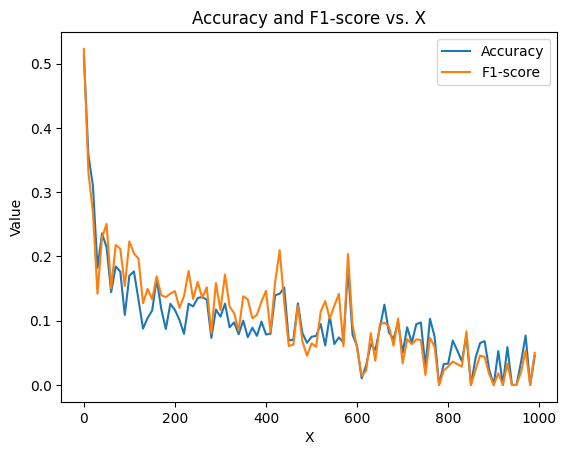

In [97]:
# Plot the accuracy and F1-score for each value of x
plt.plot(range(0, max_X*10, 10), accuracy_list_one, label='Accuracy')
plt.plot(range(0, max_X*10, 10), f1_score_list_one, label='F1-score')
plt.title('Accuracy and F1-score vs. X')
plt.xlabel('X')
plt.ylabel('Value')
plt.legend()
plt.show()